# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band5.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.967247 -0.095222 -0.932921 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.967247 -0.095222 -0.932921 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.967247 -0.095222 -0.932921 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.967247 -0.095222 -0.932921 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.967247 -0.095222 -0.932921 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.940128  ...  -1.0 -0.836775 -0.894159  -1.0  -1.0 -0.807794   
      201547 -0.940128  ...  -1.0 -0.836775 -0.894159  -1.0  -1.0 -0.807794   
      201548 -0.940128  ...  -1.0 -0.836775 -0.894159  -1.0  -1.0 -0.807794   
      201549 -0.940128  ...  -1.0 -0.836775 -0.894159  -1.0  -1.0 -0.807794   
      201550 -0.940128  ...  -1.0 -0.836775 -0.894159  -1.0  -1.0 -0.807794   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.935732  -1.0 -0.861740  
      201547  -1.0 -0.935732  -1.0 -0.854589  
      201548  -1.0 -0.935732  -1.0 -0.856973  
      201549  -1.0 -0.935732  -1.0 -0.856973  
      201550  -1.0 -0.935732  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0        1         2         3         4    5         6    7  \
5360 201546 -1.0 -1.00000 -0.967247 -0.095222 -0.932921 -1.0 -1.000000 -1.0   
     201547 -1.0 -1.00000 -0.505907 -1.000000 -1.000000 -1.0 -0.992092 -1.0   
     201548 -1.0 -1.00000 -0.967247 -0.095222 -0.932921 -1.0 -1.000000 -1.0   
     201549 -1.0 -0.99858 -0.591151 -1.000000 -0.981684 -1.0 -1.000000 -1.0   
     201550 -1.0 -1.00000 -0.967247 -0.095222 -0.932921 -1.0 -1.000000 -1.0   

                    8         9  ...  2039      2040      2041  2042  \
5360 201546 -1.000000 -0.940128  ...  -1.0 -0.836775 -0.894159  -1.0   
     201547 -0.988599 -1.000000  ...  -1.0 -0.766011 -1.000000  -1.0   
     201548 -1.000000 -0.940128  ...  -1.0 -0.836775 -0.894159  -1.0   
     201549 -1.000000 -0.427771  ...  -1.0 -0.490448 -1.000000  -1.0   
     201550 -1.000000 -0.940128  ...  -1.0 -0.836775 -0.894159  -1.0   

                 2043      2044  2045      2046  2047    Labels  
5360 201546 -1.000000 -0.807794  -1.0 -0.935732  -1.0 -0.990465  
     201547 -0.988028 -1.000000  -1.0 -0.811299  -1.0 -0.969011  
     201548 -1.000000 -0.807794  -1.0 -0.935732  -1.0 -0.995232  
     201549 -0.972311 -0.647288  -1.0 -0.865006  -1.0 -0.997616  
     201550 -1.000000 -0.807794  -1.0 -0.935732  -1.0 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

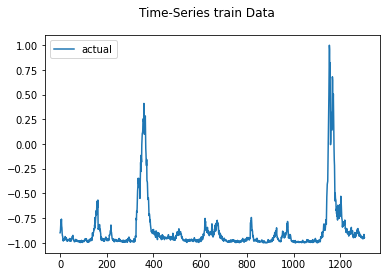

2023-03-06 14:08:29.579083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 14:08:29.579164: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 14:08:29.579192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 14:08:29.579577: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 14:08:29.946174: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 56.419
Test RMSE: 71.622
Test sMAPE: 146.745
Test R Squared: -3.721
{'mae': 56.41877305800198, 'rmse': 71.62193255289748, 'smape': 146.74451428495314, 'r2': -3.72148361352726}


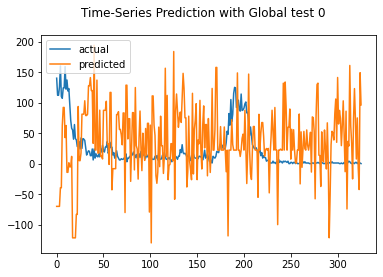

Test MAE: 110.347
Test RMSE: 128.252
Test sMAPE: 163.776
Test R Squared: -14.140
{'mae': 110.34661658556183, 'rmse': 128.25209064655397, 'smape': 163.77596918872618, 'r2': -14.139632138005151}


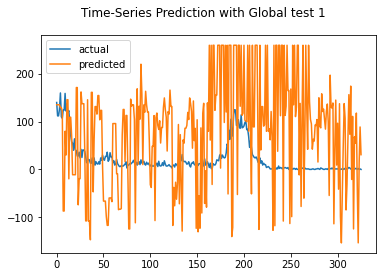

Test MAE: 79.051
Test RMSE: 102.005
Test sMAPE: 150.007
Test R Squared: -8.577
{'mae': 79.05138209151345, 'rmse': 102.00508546376774, 'smape': 150.00740855823886, 'r2': -8.577012721753773}


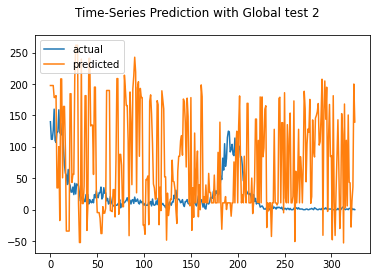

Test MAE: 66.778
Test RMSE: 100.781
Test sMAPE: 159.860
Test R Squared: -8.348
{'mae': 66.7783910538887, 'rmse': 100.78054048955187, 'smape': 159.8602697292972, 'r2': -8.348453723406612}


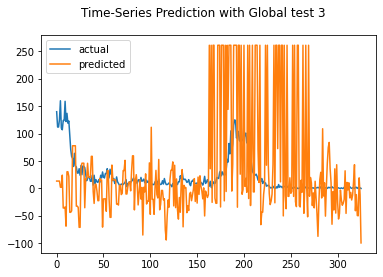

Test MAE: 56.065
Test RMSE: 85.191
Test sMAPE: 127.547
Test R Squared: -5.680
{'mae': 56.065477364085204, 'rmse': 85.1914259477365, 'smape': 127.5468095419241, 'r2': -5.6800265931775344}


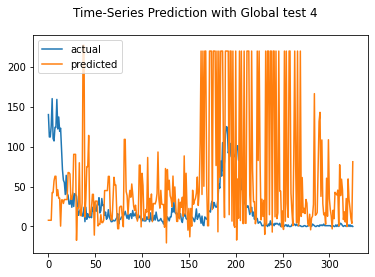

Test MAE: 90.026
Test RMSE: 116.911
Test sMAPE: 146.689
Test R Squared: -11.580
{'mae': 90.02626654450879, 'rmse': 116.91069009551792, 'smape': 146.68894676078986, 'r2': -11.580412003775086}


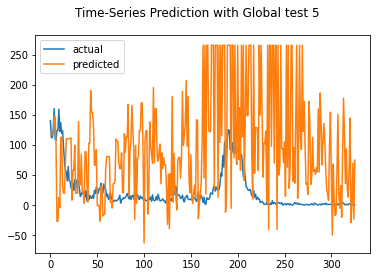

Test MAE: 88.353
Test RMSE: 100.123
Test sMAPE: 146.307
Test R Squared: -8.227
{'mae': 88.35295996051624, 'rmse': 100.12274774810683, 'smape': 146.30706300066697, 'r2': -8.226817609090697}


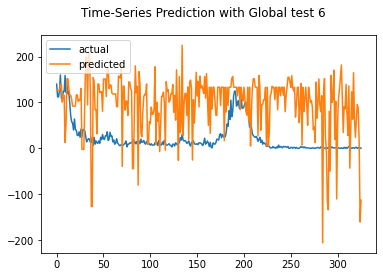

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 46.617
Test RMSE: 58.122
Test sMAPE: 134.107
Test R Squared: -2.109
{'mae': 46.61672835024588, 'rmse': 58.1221684827331, 'smape': 134.10697562272483, 'r2': -2.1093530334970327}


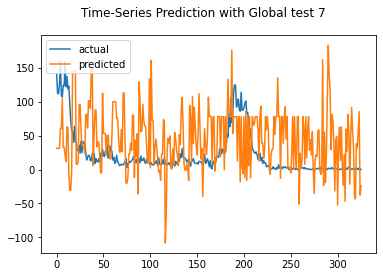

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 48.077
Test RMSE: 57.389
Test sMAPE: 132.058
Test R Squared: -2.031
{'mae': 48.07714146339089, 'rmse': 57.38881876269582, 'smape': 132.05785779885332, 'r2': -2.03138423488375}


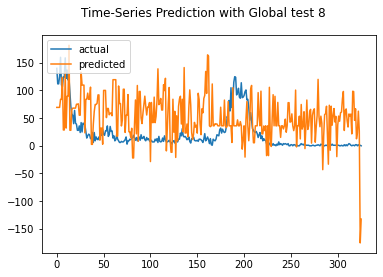

Test MAE: 67.125
Test RMSE: 74.510
Test sMAPE: 152.736
Test R Squared: -4.110
{'mae': 67.12525897523376, 'rmse': 74.51016248582413, 'smape': 152.73641861564366, 'r2': -4.109959254075896}


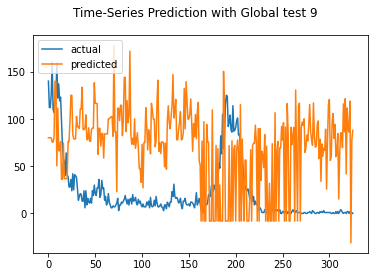

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 54.865
Test RMSE: 66.178
Test sMAPE: 136.200
Test R Squared: -3.031
{'mae': 54.86450754800823, 'rmse': 66.17836026957559, 'smape': 136.1999751481927, 'r2': -3.031052187392011}


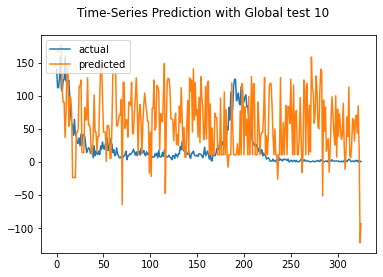

Test MAE: 50.658
Test RMSE: 58.383
Test sMAPE: 131.349
Test R Squared: -2.137
{'mae': 50.65826170283592, 'rmse': 58.38270953347817, 'smape': 131.34931642971898, 'r2': -2.137291765126424}


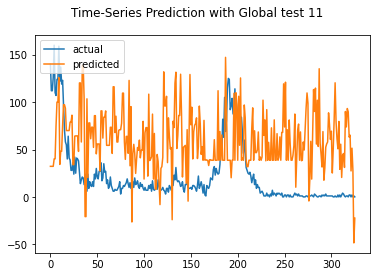

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 54.264
Test RMSE: 63.828
Test sMAPE: 137.066
Test R Squared: -2.750
{'mae': 54.264007066107965, 'rmse': 63.82840737772556, 'smape': 137.06645414833855, 'r2': -2.7498546369846726}


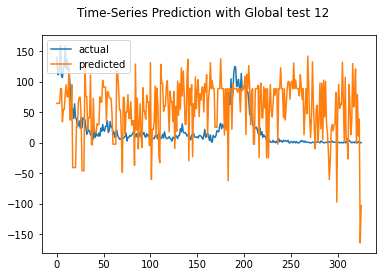

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 46.590
Test RMSE: 54.415
Test sMAPE: 130.442
Test R Squared: -1.725
{'mae': 46.58957714902843, 'rmse': 54.41454491156553, 'smape': 130.44178500798282, 'r2': -1.7253131950957696}


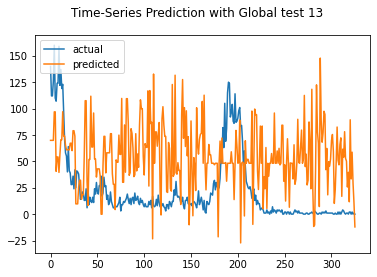

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 57.235
Test RMSE: 63.860
Test sMAPE: 135.948
Test R Squared: -2.754
{'mae': 57.23528791680658, 'rmse': 63.85980169492877, 'smape': 135.94818450980392, 'r2': -2.7535443131766155}


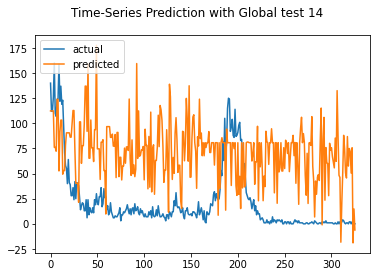

Test MAE: 71.685
Test RMSE: 94.693
Test sMAPE: 152.613
Test R Squared: -7.253
{'mae': 71.68521695680047, 'rmse': 94.69310162470876, 'smape': 152.61338259279125, 'r2': -7.253213881642987}


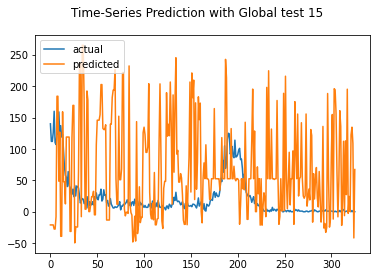

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 55.437
Test RMSE: 63.414
Test sMAPE: 135.940
Test R Squared: -2.701
{'mae': 55.437094553299474, 'rmse': 63.41406098694413, 'smape': 135.94021066955315, 'r2': -2.7013277913755935}


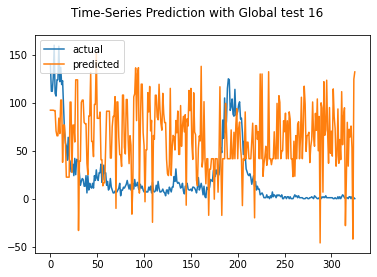

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 51.218
Test RMSE: 61.249
Test sMAPE: 136.710
Test R Squared: -2.453
{'mae': 51.218120592869134, 'rmse': 61.248883176171894, 'smape': 136.71010183008738, 'r2': -2.452890169543298}


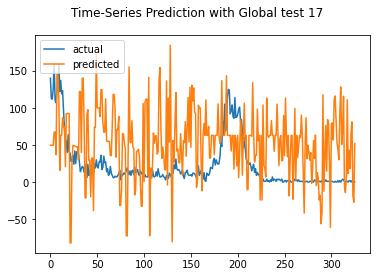

Test MAE: 53.296
Test RMSE: 63.200
Test sMAPE: 132.670
Test R Squared: -2.676
{'mae': 53.296130347105624, 'rmse': 63.200244460539395, 'smape': 132.6697282920567, 'r2': -2.6764099473481853}


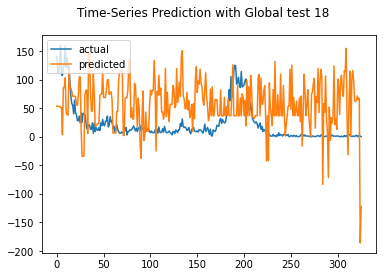

Test MAE: 42.268
Test RMSE: 51.604
Test sMAPE: 137.413
Test R Squared: -1.451
{'mae': 42.26779101962692, 'rmse': 51.6035632726962, 'smape': 137.41319975941198, 'r2': -1.451014036550863}


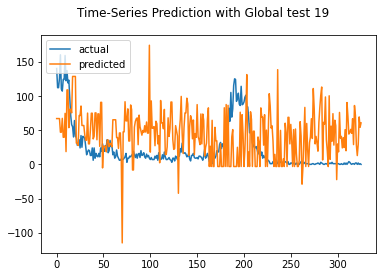

Test MAE: 81.521
Test RMSE: 105.211
Test sMAPE: 142.980
Test R Squared: -9.189
{'mae': 81.52138053127594, 'rmse': 105.21127451007224, 'smape': 142.98016569452713, 'r2': -9.188517116759584}


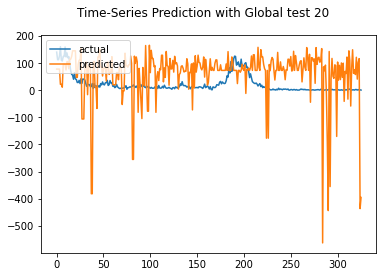

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 52.285
Test RMSE: 62.417
Test sMAPE: 148.158
Test R Squared: -2.586
{'mae': 52.28482774722796, 'rmse': 62.41676352492662, 'smape': 148.15763466665504, 'r2': -2.5858234860787688}


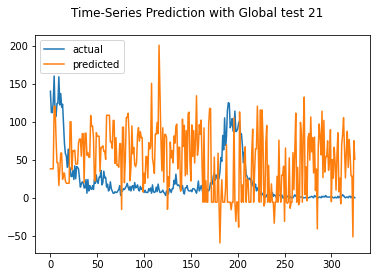

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 53.045
Test RMSE: 65.370
Test sMAPE: 144.391
Test R Squared: -2.933
{'mae': 53.045067905465515, 'rmse': 65.37017613618265, 'smape': 144.39118800101872, 'r2': -2.9331972470082093}


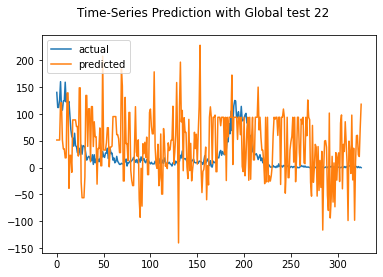

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 36.643
Test RMSE: 46.385
Test sMAPE: 125.226
Test R Squared: -0.980
{'mae': 36.64349766733822, 'rmse': 46.384525034922405, 'smape': 125.22636025982736, 'r2': -0.9803075535062633}


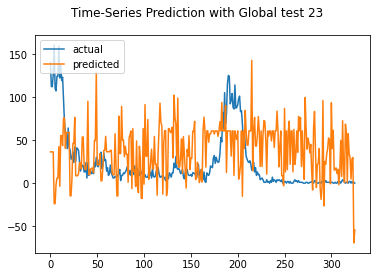

Test MAE: 42.169
Test RMSE: 56.897
Test sMAPE: 131.440
Test R Squared: -1.980
{'mae': 42.16946357452065, 'rmse': 56.89736692839837, 'smape': 131.44037967852267, 'r2': -1.9796877380006515}


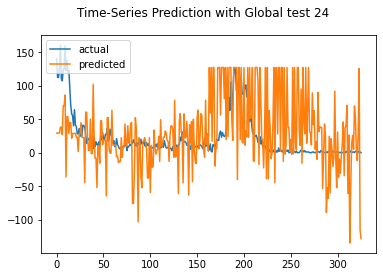

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 40.396
Test RMSE: 48.907
Test sMAPE: 132.405
Test R Squared: -1.202
{'mae': 40.39550974800543, 'rmse': 48.90671301398203, 'smape': 132.40470650090296, 'r2': -1.201523707306169}


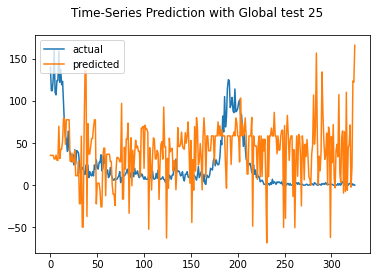

Test MAE: 58.205
Test RMSE: 72.822
Test sMAPE: 140.034
Test R Squared: -3.881
{'mae': 58.20477928513764, 'rmse': 72.82245730462641, 'smape': 140.03412008734344, 'r2': -3.8810929210852496}


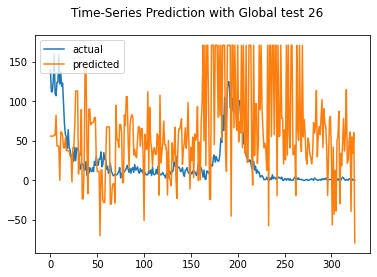

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 49.537
Test RMSE: 62.928
Test sMAPE: 156.718
Test R Squared: -2.645
{'mae': 49.537113921682526, 'rmse': 62.92844735923929, 'smape': 156.71805869209538, 'r2': -2.6448566225269254}


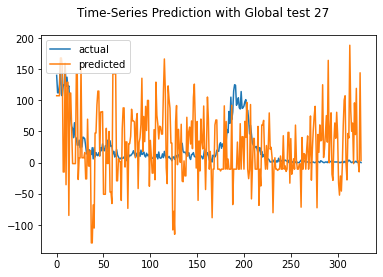

Test MAE: 133.878
Test RMSE: 151.309
Test sMAPE: 162.191
Test R Squared: -20.073
{'mae': 133.87807031058094, 'rmse': 151.30940821033357, 'smape': 162.19138533187265, 'r2': -20.07260767342568}


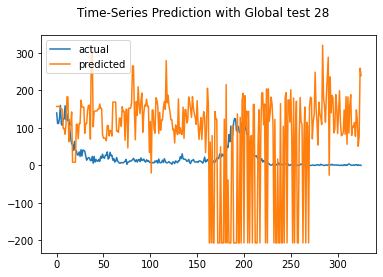

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 46.967
Test RMSE: 56.619
Test sMAPE: 144.617
Test R Squared: -1.951
{'mae': 46.96657343803008, 'rmse': 56.61921207550766, 'smape': 144.61714110667643, 'r2': -1.9506252793662262}


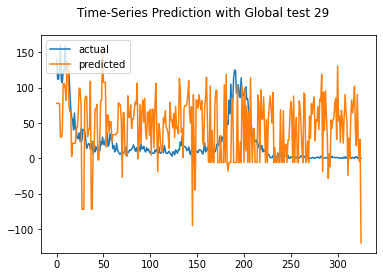

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 49.786
Test RMSE: 60.270
Test sMAPE: 130.011
Test R Squared: -2.343
{'mae': 49.78632326396696, 'rmse': 60.26953614118777, 'smape': 130.011003305396, 'r2': -2.3433520853962952}


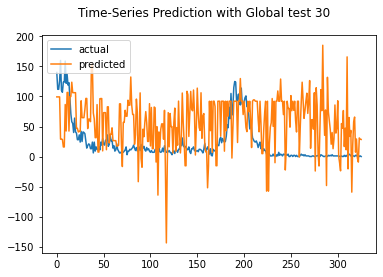

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.630
Test RMSE: 58.248
Test sMAPE: 132.517
Test R Squared: -2.123
{'mae': 47.63010726768546, 'rmse': 58.24785823486669, 'smape': 132.51664017127277, 'r2': -2.122815586310033}


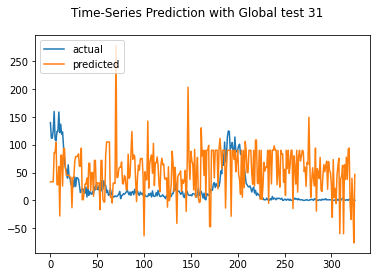

Test MAE: 67.369
Test RMSE: 75.815
Test sMAPE: 137.882
Test R Squared: -4.291
{'mae': 67.36925690598284, 'rmse': 75.81503261446954, 'smape': 137.88231847406294, 'r2': -4.290504260750909}


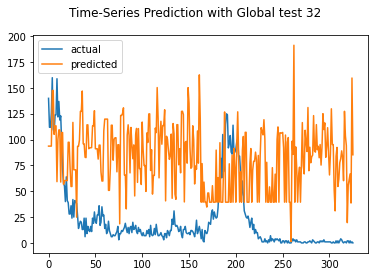

Test MAE: 46.153
Test RMSE: 59.264
Test sMAPE: 148.268
Test R Squared: -2.233
{'mae': 46.1527815995955, 'rmse': 59.26370196684041, 'smape': 148.26810742898425, 'r2': -2.232689327861329}


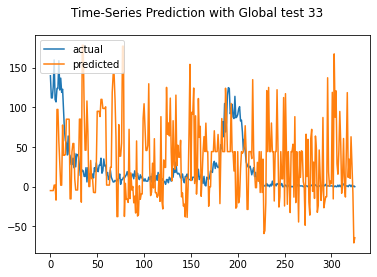

Test MAE: 48.813
Test RMSE: 58.675
Test sMAPE: 129.180
Test R Squared: -2.169
{'mae': 48.81344312612264, 'rmse': 58.67499354381923, 'smape': 129.17961900537608, 'r2': -2.1687831291252806}


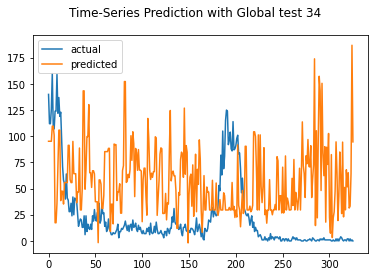

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 49.376
Test RMSE: 59.213
Test sMAPE: 132.543
Test R Squared: -2.227
{'mae': 49.3757088347081, 'rmse': 59.21278858592382, 'smape': 132.54335271732907, 'r2': -2.227137314087029}


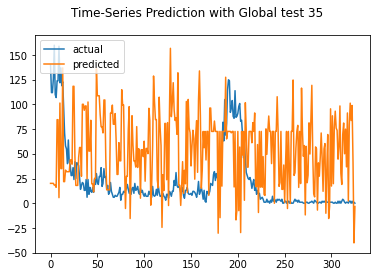

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 60.922
Test RMSE: 72.816
Test sMAPE: 139.180
Test R Squared: -3.880
{'mae': 60.922359233070736, 'rmse': 72.8162387728639, 'smape': 139.18006183352722, 'r2': -3.8802593338509963}


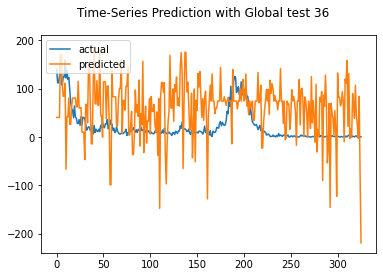

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 55.412
Test RMSE: 64.617
Test sMAPE: 134.512
Test R Squared: -2.843
{'mae': 55.41152712081108, 'rmse': 64.61727714913711, 'smape': 134.51196712076757, 'r2': -2.8431180379509837}


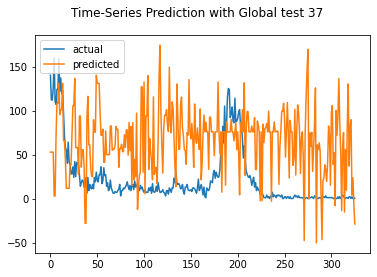

Test MAE: 46.620
Test RMSE: 61.929
Test sMAPE: 135.062
Test R Squared: -2.530
{'mae': 46.620009898590894, 'rmse': 61.92940019229309, 'smape': 135.06248837277715, 'r2': -2.5300443660263148}


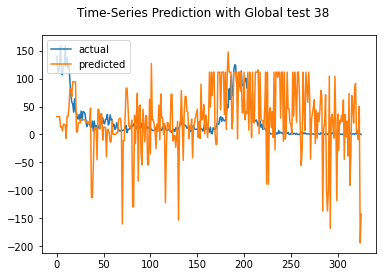

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 50.106
Test RMSE: 57.486
Test sMAPE: 130.205
Test R Squared: -2.042
{'mae': 50.10608844742453, 'rmse': 57.48572303814036, 'smape': 130.204571473685, 'r2': -2.0416302064662823}


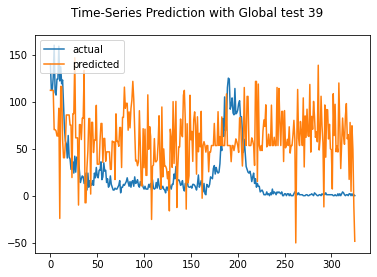

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 52.724
Test RMSE: 67.628
Test sMAPE: 143.578
Test R Squared: -3.210
{'mae': 52.72357635501704, 'rmse': 67.62789447684062, 'smape': 143.5781726729608, 'r2': -3.2095740049325716}


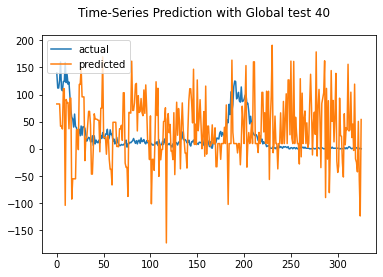

Test MAE: 63.312
Test RMSE: 73.519
Test sMAPE: 147.952
Test R Squared: -3.975
{'mae': 63.311682748191195, 'rmse': 73.51857578361344, 'smape': 147.9518794150726, 'r2': -3.9748568280737615}


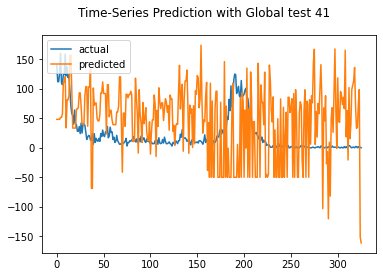

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 45.943
Test RMSE: 60.541
Test sMAPE: 144.296
Test R Squared: -2.374
{'mae': 45.94297282132634, 'rmse': 60.541401911557, 'smape': 144.2964587694561, 'r2': -2.373582715772404}


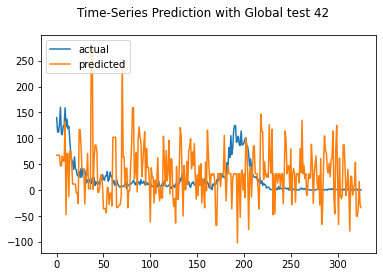

Test MAE: 70.280
Test RMSE: 102.377
Test sMAPE: 132.817
Test R Squared: -8.647
{'mae': 70.28045269993186, 'rmse': 102.37681469117692, 'smape': 132.81749932552646, 'r2': -8.64694143836584}


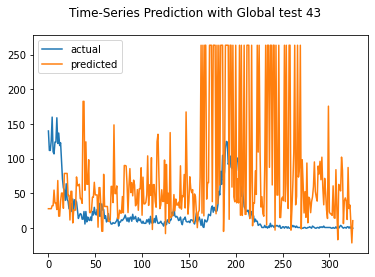

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 52.304
Test RMSE: 60.078
Test sMAPE: 138.788
Test R Squared: -2.322
{'mae': 52.303978326861845, 'rmse': 60.077963540899034, 'smape': 138.78750126506708, 'r2': -2.3221315233593405}


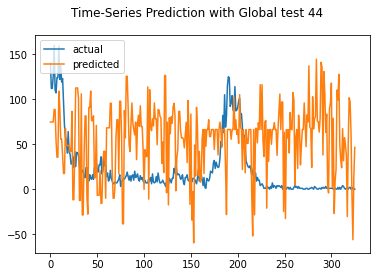

Test MAE: 48.442
Test RMSE: 72.779
Test sMAPE: 127.403
Test R Squared: -3.875
{'mae': 48.44199892659129, 'rmse': 72.7785070003705, 'smape': 127.40268326571959, 'r2': -3.875202958264124}


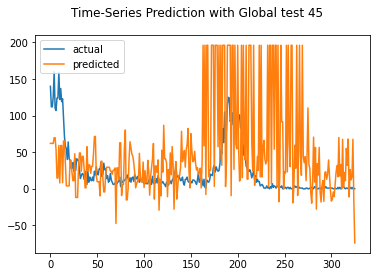

Test MAE: 46.009
Test RMSE: 53.822
Test sMAPE: 125.687
Test R Squared: -1.666
{'mae': 46.009110363714534, 'rmse': 53.82189834367754, 'smape': 125.68735085771075, 'r2': -1.6662719235106591}


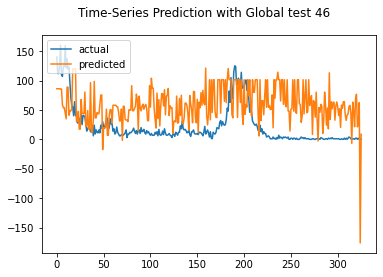

Test MAE: 73.628
Test RMSE: 86.130
Test sMAPE: 146.783
Test R Squared: -5.828
{'mae': 73.62827186131038, 'rmse': 86.13037652324567, 'smape': 146.78283375012722, 'r2': -5.828087970020807}


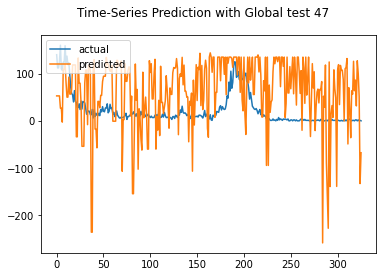

Test MAE: 99.308
Test RMSE: 121.961
Test sMAPE: 166.947
Test R Squared: -12.691
{'mae': 99.30846019244633, 'rmse': 121.96141109289407, 'smape': 166.94691162833536, 'r2': -12.690877898142999}


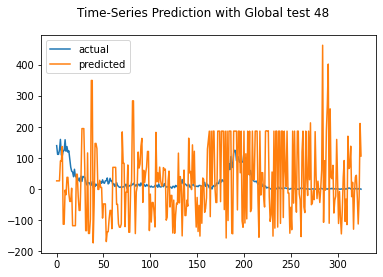

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 51.429
Test RMSE: 59.707
Test sMAPE: 137.982
Test R Squared: -2.281
{'mae': 51.428750866761234, 'rmse': 59.70669666597378, 'smape': 137.98212185382005, 'r2': -2.281198499943653}


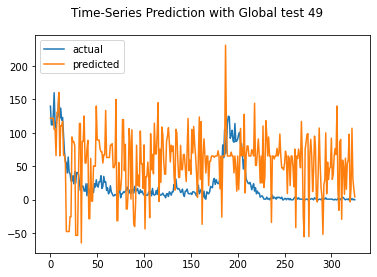

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 55.290
Test RMSE: 67.156
Test sMAPE: 135.497
Test R Squared: -3.151
{'mae': 55.29018756911798, 'rmse': 67.15571807759396, 'smape': 135.49659892844738, 'r2': -3.150996916055967}


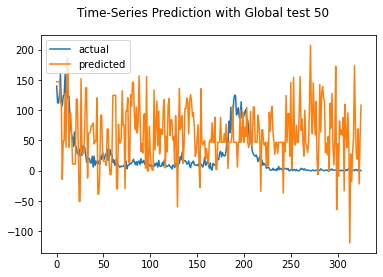

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 55.116
Test RMSE: 68.174
Test sMAPE: 136.246
Test R Squared: -3.278
{'mae': 55.11577795637897, 'rmse': 68.17435356268949, 'smape': 136.24645149429782, 'r2': -3.2778787738960524}


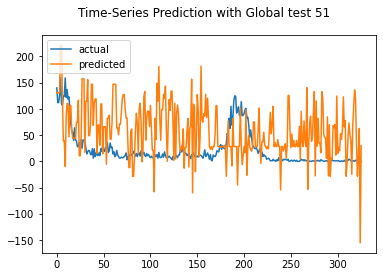

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 75.105
Test RMSE: 90.268
Test sMAPE: 148.987
Test R Squared: -6.500
{'mae': 75.10483020379499, 'rmse': 90.26823193227776, 'smape': 148.98683920772598, 'r2': -6.4999140854732875}


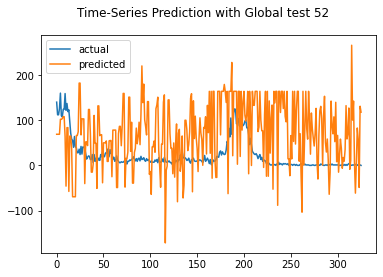

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 50.029
Test RMSE: 61.242
Test sMAPE: 135.149
Test R Squared: -2.452
{'mae': 50.02934720837997, 'rmse': 61.24213975457869, 'smape': 135.14930508100952, 'r2': -2.452129894053011}


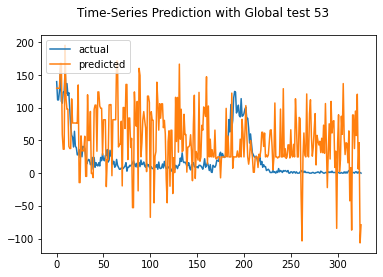

Test MAE: 51.117
Test RMSE: 58.897
Test sMAPE: 135.399
Test R Squared: -2.193
{'mae': 51.117263184003306, 'rmse': 58.8970057859379, 'smape': 135.39853796337346, 'r2': -2.1928083418963293}


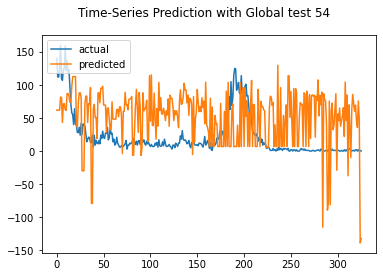

Test MAE: 59.196
Test RMSE: 78.012
Test sMAPE: 134.724
Test R Squared: -4.602
{'mae': 59.195916371202905, 'rmse': 78.01248250638581, 'smape': 134.7239211668348, 'r2': -4.601632493098202}


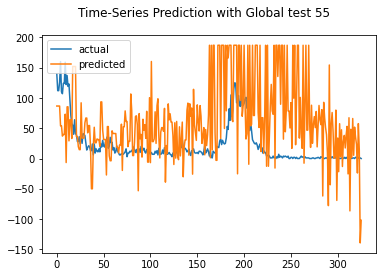

Test MAE: 55.644
Test RMSE: 66.093
Test sMAPE: 137.182
Test R Squared: -3.021
{'mae': 55.644408315237314, 'rmse': 66.09344428323598, 'smape': 137.18169404091464, 'r2': -3.020714029677743}


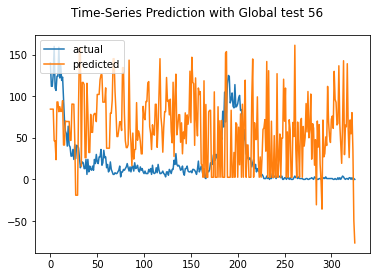

Test MAE: 51.416
Test RMSE: 57.405
Test sMAPE: 131.788
Test R Squared: -2.033
{'mae': 51.41639402088212, 'rmse': 57.40514218452945, 'smape': 131.78788445309436, 'r2': -2.0331089471874226}


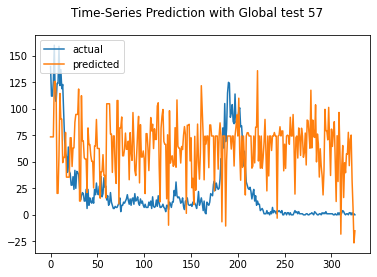

Test MAE: 76.387
Test RMSE: 96.145
Test sMAPE: 145.431
Test R Squared: -7.508
{'mae': 76.38653039804265, 'rmse': 96.14477121331525, 'smape': 145.43135849189986, 'r2': -7.50820130596391}


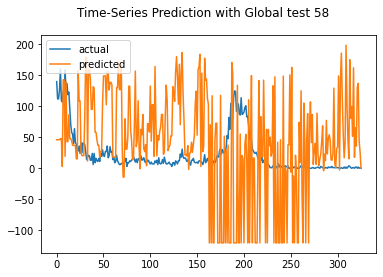

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 35.592
Test RMSE: 45.909
Test sMAPE: 129.068
Test R Squared: -0.940
{'mae': 35.59232012497867, 'rmse': 45.90885943999653, 'smape': 129.06819053409606, 'r2': -0.9399003561979444}


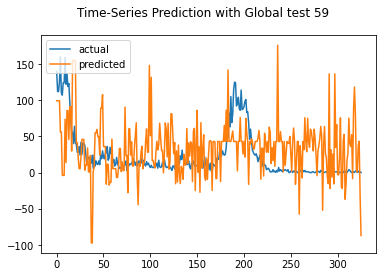

Test MAE: 66.747
Test RMSE: 91.584
Test sMAPE: 133.028
Test R Squared: -6.720
{'mae': 66.74706305024083, 'rmse': 91.58400572245, 'smape': 133.02830821406394, 'r2': -6.720149064159724}


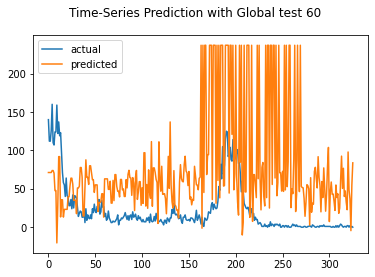

Test MAE: 44.673
Test RMSE: 54.330
Test sMAPE: 127.008
Test R Squared: -1.717
{'mae': 44.6725638615756, 'rmse': 54.330012958826224, 'smape': 127.00809037883872, 'r2': -1.7168523284581712}


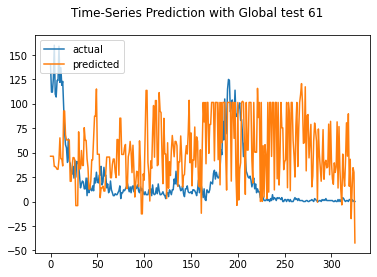

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 43.726
Test RMSE: 52.598
Test sMAPE: 133.212
Test R Squared: -1.546
{'mae': 43.72584065685243, 'rmse': 52.59833513913826, 'smape': 133.21205485535734, 'r2': -1.546422201268475}


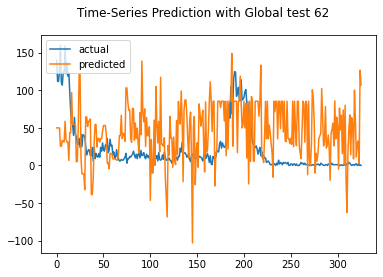

Test MAE: 51.699
Test RMSE: 64.446
Test sMAPE: 139.226
Test R Squared: -2.823
{'mae': 51.69936363344178, 'rmse': 64.44633809466377, 'smape': 139.2263236201887, 'r2': -2.822811703273173}


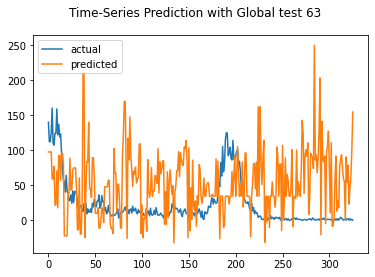

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 48.414
Test RMSE: 57.499
Test sMAPE: 134.718
Test R Squared: -2.043
{'mae': 48.41370135637149, 'rmse': 57.49913662155284, 'smape': 134.71835775692034, 'r2': -2.043049825749748}


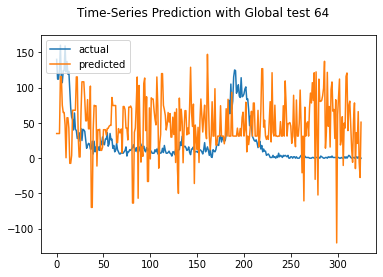

Test MAE: 56.084
Test RMSE: 73.780
Test sMAPE: 149.459
Test R Squared: -4.010
{'mae': 56.08448070635094, 'rmse': 73.7795206560527, 'smape': 149.45927546904753, 'r2': -4.01023474990608}


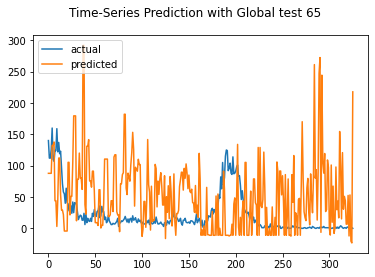

Test MAE: 44.127
Test RMSE: 57.345
Test sMAPE: 138.896
Test R Squared: -2.027
{'mae': 44.12670885273284, 'rmse': 57.344504511093575, 'smape': 138.895815756301, 'r2': -2.026704519843743}


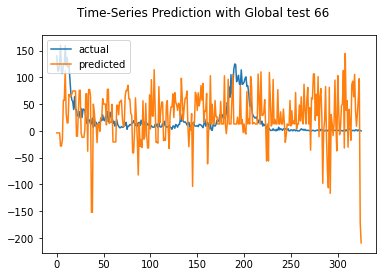

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 53.411
Test RMSE: 67.734
Test sMAPE: 141.587
Test R Squared: -3.223
{'mae': 53.41108637700783, 'rmse': 67.73358488280792, 'smape': 141.58721946943774, 'r2': -3.222741921749412}


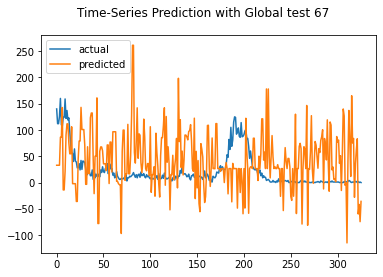

Test MAE: 70.997
Test RMSE: 78.722
Test sMAPE: 141.584
Test R Squared: -4.704
{'mae': 70.9965032821784, 'rmse': 78.72230879499776, 'smape': 141.5840053476395, 'r2': -4.704033424228544}


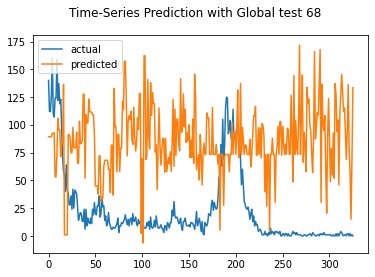

Test MAE: 74.860
Test RMSE: 83.232
Test sMAPE: 142.109
Test R Squared: -5.376
{'mae': 74.8599434961205, 'rmse': 83.2319245264062, 'smape': 142.10862730472707, 'r2': -5.376263993016315}


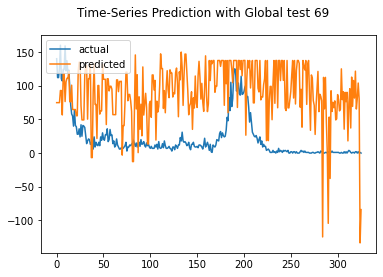

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 60.000
Test RMSE: 71.903
Test sMAPE: 148.998
Test R Squared: -3.759
{'mae': 60.00029099462954, 'rmse': 71.90277966125622, 'smape': 148.99789719992683, 'r2': -3.7585843950116535}


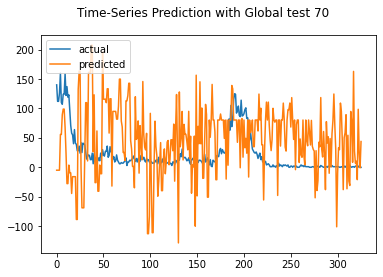

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 47.216
Test RMSE: 55.890
Test sMAPE: 131.501
Test R Squared: -1.875
{'mae': 47.21554222584136, 'rmse': 55.89043239658517, 'smape': 131.50148912107804, 'r2': -1.875155614241816}


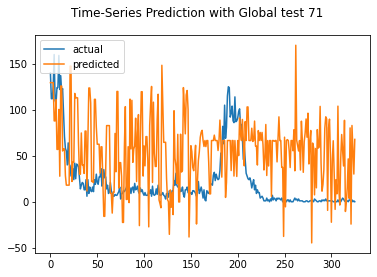

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 51.441
Test RMSE: 65.156
Test sMAPE: 143.584
Test R Squared: -2.907
{'mae': 51.44143992772132, 'rmse': 65.15606295603901, 'smape': 143.58369433496426, 'r2': -2.907473890142473}


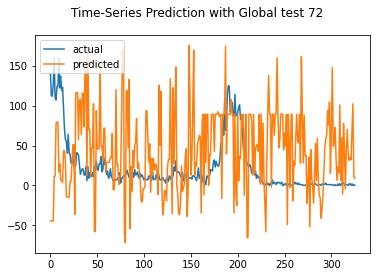

Test MAE: 50.708
Test RMSE: 58.675
Test sMAPE: 133.046
Test R Squared: -2.169
{'mae': 50.70822077441069, 'rmse': 58.67476588463627, 'smape': 133.04624352816802, 'r2': -2.168758539393436}


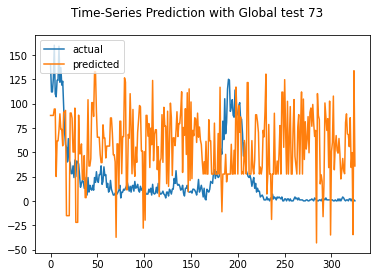

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 47.762
Test RMSE: 57.852
Test sMAPE: 141.986
Test R Squared: -2.081
{'mae': 47.7616456801906, 'rmse': 57.852184258706885, 'smape': 141.98585634326838, 'r2': -2.0805335122901836}


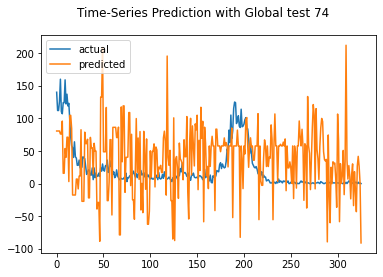

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 48.617
Test RMSE: 62.395
Test sMAPE: 135.067
Test R Squared: -2.583
{'mae': 48.61749247621539, 'rmse': 62.3953481396814, 'smape': 135.0671328406511, 'r2': -2.583363293871138}


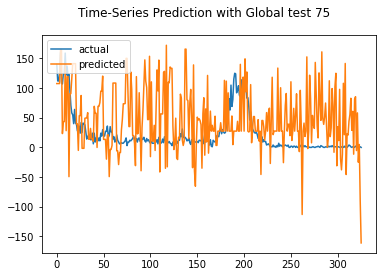

Test MAE: 104.578
Test RMSE: 132.947
Test sMAPE: 162.179
Test R Squared: -15.268
{'mae': 104.57810228880197, 'rmse': 132.9468084741981, 'smape': 162.17937457708436, 'r2': -15.268302842758338}


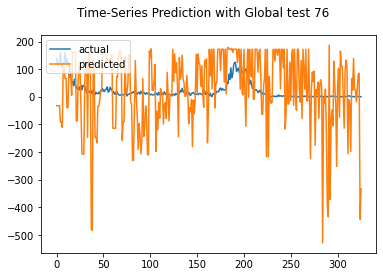

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 50.787
Test RMSE: 63.187
Test sMAPE: 129.082
Test R Squared: -2.675
{'mae': 50.7869389437459, 'rmse': 63.186899232163505, 'smape': 129.08245177709975, 'r2': -2.674857505556225}


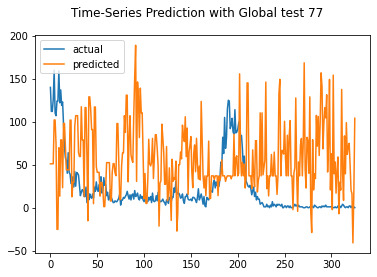

Test MAE: 92.583
Test RMSE: 108.103
Test sMAPE: 154.931
Test R Squared: -9.756
{'mae': 92.58338317110494, 'rmse': 108.10261284716863, 'smape': 154.93101547893878, 'r2': -9.756198250426262}


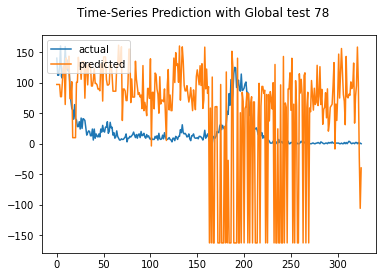

Test MAE: 67.695
Test RMSE: 82.641
Test sMAPE: 155.245
Test R Squared: -5.286
{'mae': 67.69548838178804, 'rmse': 82.64081487860996, 'smape': 155.2448542002243, 'r2': -5.286017677275432}


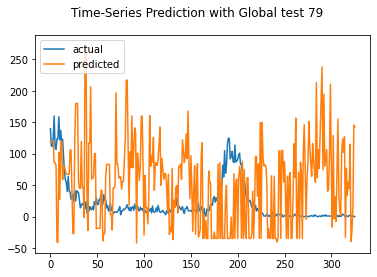

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 50.993
Test RMSE: 59.928
Test sMAPE: 135.008
Test R Squared: -2.306
{'mae': 50.993350633265784, 'rmse': 59.92757984615894, 'smape': 135.00842180725672, 'r2': -2.305520802705013}


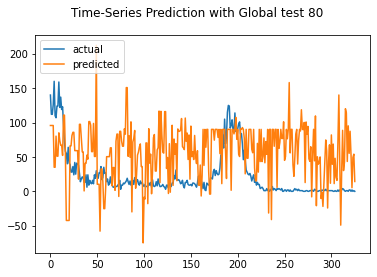

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 45.084
Test RMSE: 52.191
Test sMAPE: 129.400
Test R Squared: -1.507
{'mae': 45.08400532347293, 'rmse': 52.191127661626744, 'smape': 129.40032691256337, 'r2': -1.5071468774428305}


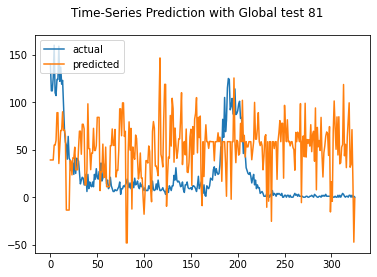

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 47.652
Test RMSE: 58.326
Test sMAPE: 132.399
Test R Squared: -2.131
{'mae': 47.65231554347313, 'rmse': 58.32570435248238, 'smape': 132.39895305625237, 'r2': -2.1311682201500743}


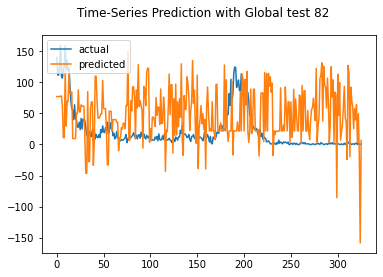

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 51.947
Test RMSE: 64.677
Test sMAPE: 142.183
Test R Squared: -2.850
{'mae': 51.94678812396307, 'rmse': 64.67708049324658, 'smape': 142.1829216439325, 'r2': -2.850234947705053}


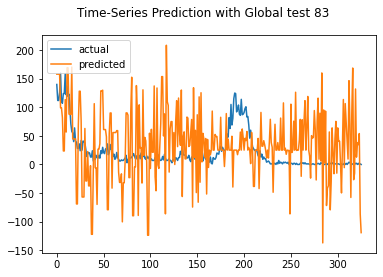

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 58.031
Test RMSE: 66.554
Test sMAPE: 134.945
Test R Squared: -3.077
{'mae': 58.03100480038695, 'rmse': 66.55356473062696, 'smape': 134.9451388535776, 'r2': -3.0768906245935552}


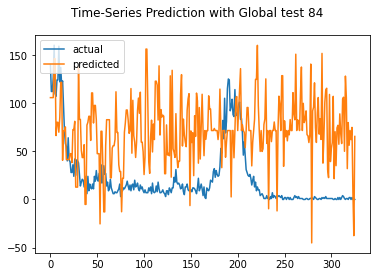

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 34.899
Test RMSE: 47.151
Test sMAPE: 135.459
Test R Squared: -1.046
{'mae': 34.899286907691895, 'rmse': 47.15059821874669, 'smape': 135.4588346028265, 'r2': -1.0462600742707435}


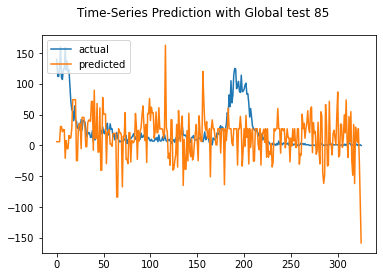

Test MAE: 52.489
Test RMSE: 65.771
Test sMAPE: 130.978
Test R Squared: -2.982
{'mae': 52.48947572561861, 'rmse': 65.77113144070171, 'smape': 130.97831575705274, 'r2': -2.9815946311943025}


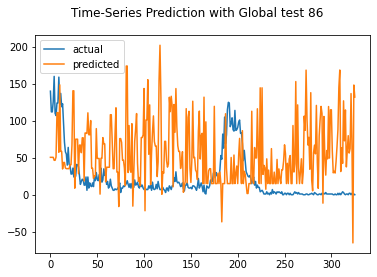

Test MAE: 63.502
Test RMSE: 70.095
Test sMAPE: 138.181
Test R Squared: -3.522
{'mae': 63.50182160570578, 'rmse': 70.09487538951673, 'smape': 138.18069469563275, 'r2': -3.522295658716673}


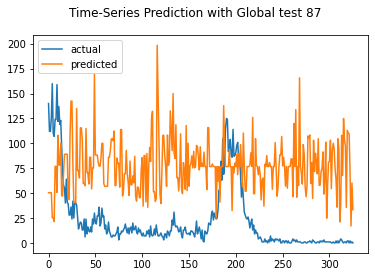

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 42.837
Test RMSE: 51.089
Test sMAPE: 127.361
Test R Squared: -1.402
{'mae': 42.83709374527258, 'rmse': 51.088674682548856, 'smape': 127.36083131947186, 'r2': -1.402346730957719}


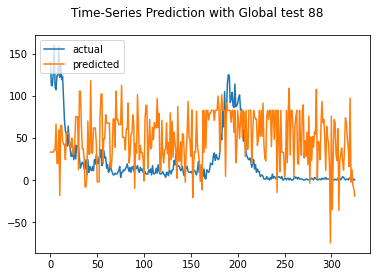

Test MAE: 77.829
Test RMSE: 96.401
Test sMAPE: 144.844
Test R Squared: -7.554
{'mae': 77.82899233314889, 'rmse': 96.40098477161229, 'smape': 144.84388080248442, 'r2': -7.553608270972761}


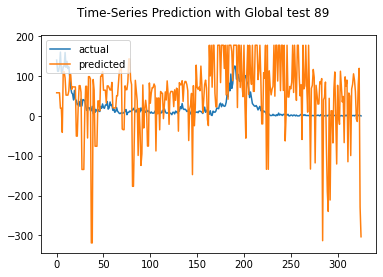

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 60.867
Test RMSE: 73.810
Test sMAPE: 142.270
Test R Squared: -4.014
{'mae': 60.866847398822294, 'rmse': 73.81019718280642, 'smape': 142.2697045305395, 'r2': -4.014401991749474}


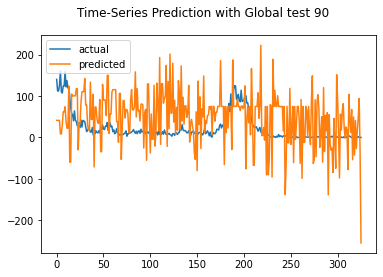

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 46.530
Test RMSE: 57.915
Test sMAPE: 132.684
Test R Squared: -2.087
{'mae': 46.530457334558655, 'rmse': 57.91450620321359, 'smape': 132.6839208004223, 'r2': -2.0871741689922834}


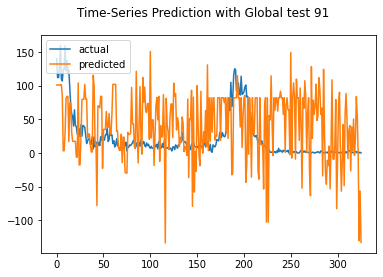

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 51.328
Test RMSE: 63.197
Test sMAPE: 148.240
Test R Squared: -2.676
{'mae': 51.32770838986145, 'rmse': 63.197233820705875, 'smape': 148.2398685758645, 'r2': -2.6760596929244067}


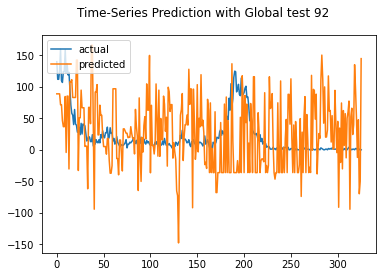

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 35.919
Test RMSE: 44.581
Test sMAPE: 130.460
Test R Squared: -0.829
{'mae': 35.91929770210769, 'rmse': 44.58064873681452, 'smape': 130.4597045882323, 'r2': -0.8292757800855923}


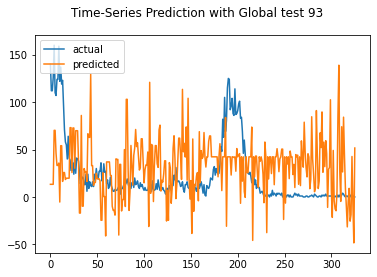

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 48.259
Test RMSE: 61.681
Test sMAPE: 132.566
Test R Squared: -2.502
{'mae': 48.25905719344601, 'rmse': 61.68061809457608, 'smape': 132.5664770296493, 'r2': -2.5017396232621523}


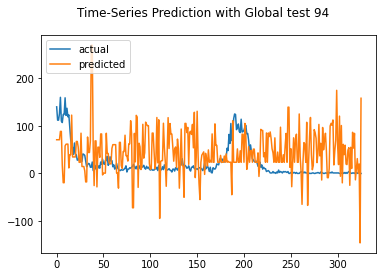

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 49.453
Test RMSE: 59.929
Test sMAPE: 129.519
Test R Squared: -2.306
{'mae': 49.45326728689159, 'rmse': 59.92860112736537, 'smape': 129.51916219847814, 'r2': -2.30563346852758}


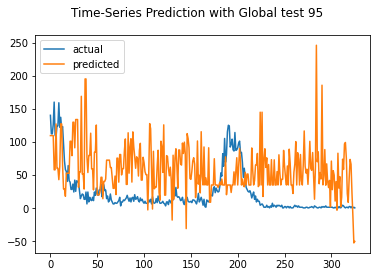

Test MAE: 131.407
Test RMSE: 150.577
Test sMAPE: 161.131
Test R Squared: -19.869
{'mae': 131.40705053060333, 'rmse': 150.57745318347804, 'smape': 161.1308958029981, 'r2': -19.86922449683492}


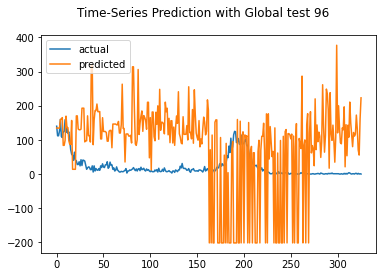

Test MAE: 66.878
Test RMSE: 81.743
Test sMAPE: 161.470
Test R Squared: -5.150
{'mae': 66.87774262508732, 'rmse': 81.7431886731713, 'smape': 161.4702024115086, 'r2': -5.150204630347937}


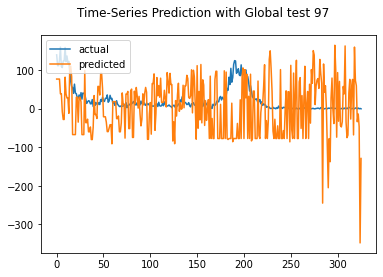

Test MAE: 70.143
Test RMSE: 85.766
Test sMAPE: 137.850
Test R Squared: -5.770
{'mae': 70.14260764246337, 'rmse': 85.76636980185647, 'smape': 137.8503566975402, 'r2': -5.770495795632544}


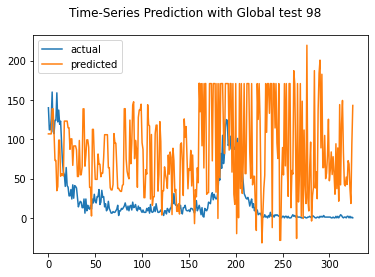

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 39.203
Test RMSE: 46.923
Test sMAPE: 127.113
Test R Squared: -1.027
{'mae': 39.203124686527104, 'rmse': 46.92302660673993, 'smape': 127.11292049250285, 'r2': -1.0265552584204314}


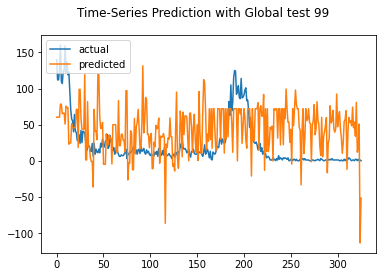

rmse : average=71.391, std=21.400
mae : average=58.329, std=17.908
smape : average=139.559, std=9.593
r2 : average=-4.113, std=3.599


([71.39093468747271, 21.399515577475437],
 [58.3285820631052, 17.90754060078632],
 [139.5591965573058, 9.59326243871479],
 [-4.112573717443109, 3.599133746507683])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
